## Generating a Table of Global Fluxes

This notebook reads time series data from `Make Timeseries.ipynb` and
generates plots of variables listed in [issue #22](https://github.com/marbl-ecosys/cesm2-marbl/issues/22)

### This notebook uses several python packages

The watermark package shows the version number used to help others recreate this environment.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pandas as pd
import ann_avg_utils as aau

# Set pandas option and get pint units
pd.set_option('display.max_colwidth', 75)
units, final_units = aau.get_pint_units()

%load_ext watermark
%watermark -d -iv -m -g -h

matplotlib 3.1.2
pandas     0.25.3
2020-01-31 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper10
Git hash   : 0bd18c0c86f63648c11c5119d56f564bc3fa2a84


### Copy data that is shared with time series plotting from aau

In [2]:
xp_dir = aau.global_vars()['xp_dir']
vars = aau.global_vars()['vars']
experiments = aau.global_vars()['experiments']
experiment_longnames = aau.global_vars()['experiment_longnames']
experiment_dict = aau.global_vars()['experiment_dict']
time_slices = aau.global_vars()['time_slices']

#### Read output from Make Timeseries.ipynb

Files were written by `xpersist` and are read in using `xr.open_dataset`

In [3]:
%%time

ann_avg, cesm_units = aau.get_ann_means_and_units(xp_dir, vars, experiments, experiment_longnames, units)

CPU times: user 1.62 s, sys: 171 ms, total: 1.79 s
Wall time: 2.41 s


## Reduce Data Sets

Data has been reduced to annual means, but the netcdf files contain every year in the dataset.
For generating tables, we want to look at specific time periods.

####  Define the time periods we will average over

This could be done earlier in the notebook, but I think it makes sense to wait until we have annual / global means.

In [4]:
# aau.print_exp_time_bounds(ann_avg[vars[0]], time_slices)

#### Define labels for rows in each table

Also determine correct number of digits to write each value out to

In [5]:
table_specs = aau.get_table_specs(final_units, o2_levs=[5, 20, 60, 80])

#### Average over all ensemble members and time (for proper time period)

In [6]:
diagnostic_values = aau.compute_diagnostic_values(experiments, table_specs, ann_avg, time_slices, cesm_units, final_units, verbose=False)

   * Can not compute SedDenitrif for cesm1_PI
   * Can not compute DON_RIV_FLUX for cesm1_PI
   * Can not compute DONr_RIV_FLUX for cesm1_PI
   * No additional denitrification terms for cesm1_PI
   * Can not compute SedDenitrif for cesm1_PI_esm
   * Can not compute DON_RIV_FLUX for cesm1_PI_esm
   * Can not compute DONr_RIV_FLUX for cesm1_PI_esm
   * No additional denitrification terms for cesm1_PI_esm
   * Can not compute SedDenitrif for cesm1_hist
   * Can not compute DON_RIV_FLUX for cesm1_hist
   * Can not compute DONr_RIV_FLUX for cesm1_hist
   * No additional denitrification terms for cesm1_hist
   * Can not compute SedDenitrif for cesm1_hist_esm
   * Can not compute DON_RIV_FLUX for cesm1_hist_esm
   * Can not compute DONr_RIV_FLUX for cesm1_hist_esm
   * No additional denitrification terms for cesm1_hist_esm
   * Can not compute SedDenitrif for cesm1_RCP85
   * Can not compute DON_RIV_FLUX for cesm1_RCP85
   * Can not compute DONr_RIV_FLUX for cesm1_RCP85
   * No additional den

#### Make timeseries plots

In [7]:
tseries_keys = dict()
tseries_keys['FG_CO2'] = table_specs['CO2']['key']
tseries_keys['photoC_TOT_zint'] = table_specs['NPP']['key']
tseries_keys['O2'] = table_specs['O2']['key']
tseries_keys['POC_FLUX_100m'] = table_specs['POC']['key']

In [8]:
def make_timeseries_plot(var, exp, exp_in_title=None, plot_all=True, plot_mean=None):
    plot_mean = len(ann_avg[var][exp]['member_id'] > 1) if plot_mean is None else plot_mean
    num_plots = plot_all + plot_mean
    if num_plots == 0:
        print('Not plotting anything!')
        return None, None

    fig, ax = plt.subplots(figsize=(7, 6))
    # plot each ensemble member
    time = ann_avg[var][exp]['time']
    if plot_all:
        loc_var = (ann_avg[var][exp][var].data.T * units[ann_avg[var][exp][var].attrs['units']]).to(final_units[var]).magnitude
        plt.plot(time, loc_var)
    # add ensemble mean if there is more than one member
    if plot_mean:
        loc_ens_mean = (ann_avg[var][exp][var].mean('member_id').data * units[ann_avg[var][exp][var].attrs['units']]).to(final_units[var]).magnitude
        plt.plot(time, loc_ens_mean, 'k')

    # Set up title (include exp_in_title if provided)
    if exp_in_title:
        var_loc='left'
        plt.title(exp_in_title, loc='right')
    else:
        var_loc='center'
    # Main title should be corresponding key from table,
    # but without the units in parentheses
    plt.title(tseries_keys[var], loc=var_loc)

    plt.xlabel('Year')
    plt.ylabel(final_units[var])
    return(fig, ax)

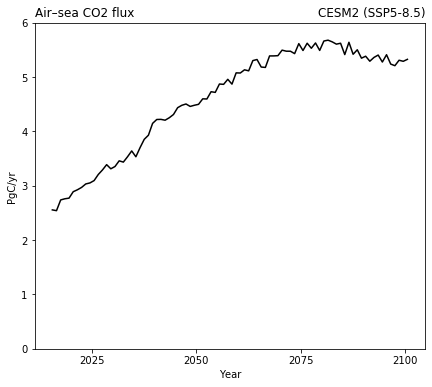

In [9]:
fig, ax = make_timeseries_plot('FG_CO2', 'cesm2_SSP5-8.5', exp_in_title='CESM2 (SSP5-8.5)', plot_all=False)
ax.set_ylim([0, 6])
plt.show()

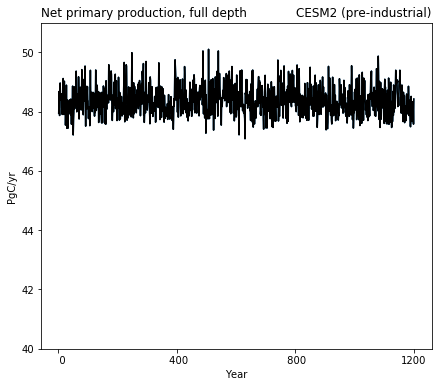

In [10]:
fig, ax = make_timeseries_plot('photoC_TOT_zint', 'cesm2_PI', exp_in_title='CESM2 (pre-industrial)')
ax.set_ylim([40, 51])
plt.show()

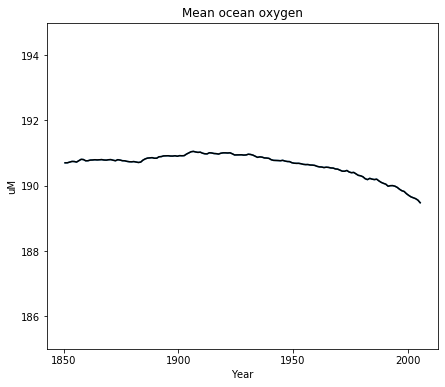

In [11]:
fig, ax = make_timeseries_plot('O2', 'cesm1_hist')
ax.set_ylim([185, 195])
plt.show()

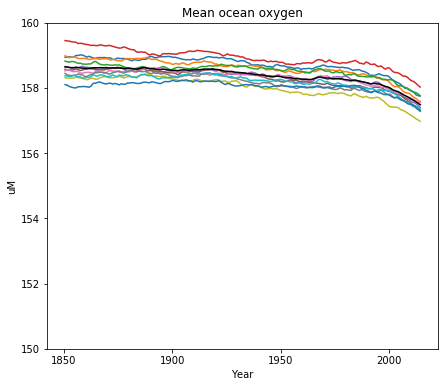

In [12]:
fig, ax = make_timeseries_plot('O2', 'cesm2_hist')
ax.set_ylim([150, 160])
plt.show()

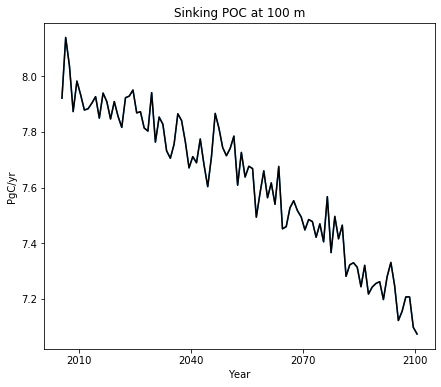

In [13]:
fig, ax = make_timeseries_plot('POC_FLUX_100m', 'cesm1_RCP85')
plt.show()

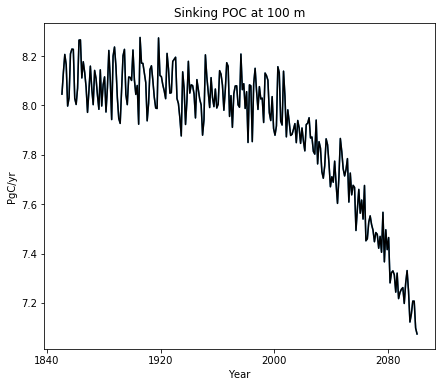

In [14]:
fig, ax = make_timeseries_plot('POC_FLUX_100m', 'cesm1_hist_RCP85')
plt.show()